# Boilerplate

Just load packages:

In [48]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from sequence_jacobian import het, simple, create_model              # functions
from sequence_jacobian import interpolate, grids, misc, estimation   # modules
from numba import vectorize

In [49]:
def bissection_onestep(f,a,b):
    if not np.all(f(a)*f(b) <= 0):
        raise ValueError("No sign change")
    else:
        mid_point = (a + b)/2
        mid_value = f(mid_point)
        new_a = a
        new_b = b
        indxs_a = np.nonzero(mid_value*f(b) <= 0)
        indxs_b = np.nonzero(mid_value*f(a) <= 0)
        if indxs_a[0].size != 0:
            new_a[indxs_a] = mid_point[indxs_a]
        if indxs_b[0].size != 0:
            new_b[indxs_b] = mid_point[indxs_b]
        return new_a,new_b

def vec_bissection(f,a,b,iter_max = 100,tol = 1E-11):
    i = 1
    err = 1
    while i < iter_max and err > tol:
        a,b = bissection_onestep(f,a,b)
        err = np.max(np.abs(a - b))
        i += 1
    if i >= iter_max:
        raise Error("No convergence")
    return a

In [50]:
def consumption(c,we,rest,gamma,v,phi,tauc):
    return (1 + tauc) * c - we * (we / ((1 + tauc) * phi * c ** gamma)) ** (1/v) - rest

In [51]:
def household_guess(a_grid,e_grid,r,w,gamma,T):
    wel = (1 + r) * a_grid[np.newaxis,:] + w * e_grid[:,np.newaxis] + T[:,np.newaxis]
    V_prime = (1 + r) * (wel * 0.1) ** (-gamma)
    return V_prime

In [52]:
@het(exogenous = 'Pi',policy = 'a', backward = 'V_prime', backward_init = household_guess)
def household(V_prime_p,a_grid,e_grid,r,w,T,beta,gamma,v,phi,tauc):

    we = w * e_grid

    c_prime = (beta * V_prime_p) ** (-1/gamma) #c_prime is the new guess for c_t
    n_prime = (we[:,np.newaxis] / ((1 + tauc) * phi * c_prime ** gamma)) ** (1/v)

    new_grid = (1 + tauc) * c_prime + a_grid[np.newaxis,:] - we[:,np.newaxis] * n_prime - T[:,np.newaxis]
    wel = (1 + r) * a_grid

    c = interpolate.interpolate_y(new_grid,wel,c_prime)
    n = interpolate.interpolate_y(new_grid,wel,n_prime)

    a = wel + we[:,np.newaxis] * n + T[:,np.newaxis] - (1 + tauc) * c
    V_prime = (1 + r) * c ** (-gamma)

    # checks for violations of the condition of minimal assets required and fixes it

    indexes_asset = np.nonzero(a < a_grid[0]) #first dimension: labor grid, second dimension: asset grid
    a[indexes_asset] = a_grid[0]

    if indexes_asset[0].size != 0 and indexes_asset[1].size !=0:

        aa = np.zeros((indexes_asset[0].size)) + 1E-5
        rest = wel[indexes_asset[1]] - a_grid[0] + T[indexes_asset[0]]
        bb = c[indexes_asset] + 0.5
        
        c[indexes_asset] = vec_bissection(lambda c : consumption(c,we[indexes_asset[0]],rest,gamma,v,phi,tauc),aa,bb)
        n[indexes_asset] = (we[indexes_asset[0]] / ((1 + tauc) * phi * c[indexes_asset] ** gamma)) ** (1/v)
        V_prime[indexes_asset] = (1 + r) * (c[indexes_asset]) ** (-gamma)

    return V_prime,a,c,n

print(household)
print(f'Inputs: {household.inputs}')
print(f'Macro outputs: {household.outputs}')
print(f'Micro outputs: {household.internals}')

<HetBlock 'household'>
Inputs: ['a_grid', 'e_grid', 'r', 'w', 'T', 'beta', 'gamma', 'v', 'phi', 'tauc', 'Pi']
Macro outputs: ['A', 'C', 'N']
Micro outputs: ['D', 'Dbeg', 'Pi', 'V_prime', 'a', 'c', 'n']


The rest of the code is identical to the HANK example in their notebook on their repo:

In [53]:
def make_grid(rho_e, sd_e, nE, amin, amax, nA):
    e_grid, pi_e, Pi = grids.markov_rouwenhorst(rho=rho_e, sigma=sd_e, N=nE)
    a_grid = grids.agrid(amin=amin, amax=amax, n=nA)
    return e_grid, Pi, a_grid, pi_e

def transfers(pi_e, Div, Transfer, e_grid):
    # hardwired incidence rules are proportional to skill; scale does not matter 
    tax_rule, div_rule = np.ones(e_grid.size), e_grid #np.ones(e_grid.size)
    div = Div / np.sum(pi_e * div_rule) * div_rule
    transfer =  Transfer / np.sum(pi_e * tax_rule) * tax_rule 
    T = div + transfer
    return T

household_inp= household.add_hetinputs([make_grid,transfers])

print(household_inp)
print(f'Inputs: {household_inp.inputs}')

<HetBlock 'household' with hetinput 'make_grid_transfers'>
Inputs: ['r', 'w', 'beta', 'gamma', 'v', 'phi', 'tauc', 'rho_e', 'sd_e', 'nE', 'amin', 'amax', 'nA', 'Div', 'Transfer']


In [54]:
def labor_supply(n, e_grid):
    ne = e_grid[:, np.newaxis] * n
    return ne

hh_ext = household_inp.add_hetoutputs([labor_supply])

print(hh_ext)
print(f'Outputs: {hh_ext.outputs}')
print(f'Inputs: {household_inp.inputs}')

<HetBlock 'household' with hetinput 'make_grid_transfers' and with hetoutput `labor_supply'>
Outputs: ['A', 'C', 'N', 'NE']
Inputs: ['r', 'w', 'beta', 'gamma', 'v', 'phi', 'tauc', 'rho_e', 'sd_e', 'nE', 'amin', 'amax', 'nA', 'Div', 'Transfer']


In [55]:
@simple
def firm(Y, w, Z, pi, mu, kappa):
    L = Y / Z
    Div = Y - w * L - mu/(mu-1)/(2*kappa) * (1+pi).apply(np.log)**2 * Y
    return L, Div

@simple
def monetary(pi, rstar, phi_pi):
    i = rstar(-1)
    r = (1 + i + phi_pi * pi(-1)) / (1 + pi) - 1
    return r, i

@simple
def fiscal(r, Transfer, B, tauc, C):
    govt_res = (1 + r) * B(-1) + Transfer - tauc * C - B
    return govt_res

@simple
def mkt_clearing(A, NE, C, L, Y, B, pi, mu, kappa):
    asset_mkt = A - B
    labor_mkt = NE - L
    goods_mkt = Y - C - mu / (mu - 1) / (2 * kappa) * (1 + pi).apply(np.log) ** 2 * Y
    return asset_mkt, labor_mkt, goods_mkt

@simple
def nkpc_ss(Z, mu):
    w = Z / mu
    return w

In [56]:
blocks_ss = [hh_ext, firm, monetary,fiscal, nkpc_ss, mkt_clearing]

hank_ss = create_model(blocks_ss, name = "One-Asset HANK SS")

print(hank_ss)
print(f"Inputs: {hank_ss.inputs}")
print(f"Outputs: {hank_ss.outputs}")

<Model 'One-Asset HANK SS'>
Inputs: ['beta', 'gamma', 'v', 'phi', 'tauc', 'rho_e', 'sd_e', 'nE', 'amin', 'amax', 'nA', 'Transfer', 'Y', 'Z', 'pi', 'mu', 'kappa', 'rstar', 'phi_pi', 'B']
Outputs: ['A', 'C', 'N', 'NE', 'L', 'Div', 'r', 'i', 'govt_res', 'w', 'asset_mkt', 'labor_mkt', 'goods_mkt']


In [57]:
calibration = {'gamma': 1, 'v':2, 'rho_e': 0.966, 'sd_e': 0.5, 'nE': 7,
               'amin': 0, 'amax': 150, 'nA': 500, 'Y': 1.0, 'Z': 1.0, 'pi': 0.0,
               'mu': 1.2, 'kappa': 0.1, 'rstar': 0.005, 'phi_pi': 0, 'B': 5.6, 'tauc': 0.1}

unknowns_ss = {'beta': 0.986, 'phi': 0.8, 'Transfer': -0.03}
targets_ss = {'asset_mkt': 0, 'labor_mkt': 0, 'govt_res': 0}

ss0 = hank_ss.solve_steady_state(calibration, unknowns_ss, targets_ss, solver="hybr")

In [58]:
print(f"Asset market clearing: {ss0['asset_mkt']: 0.2e}")
print(f"Labor market clearing: {ss0['labor_mkt']: 0.2e}")
print(f"Govt Budget Constraint: {ss0['govt_res']: 0.2e}")
print(f"Goods market clearing (untargeted): {ss0['goods_mkt']: 0.2e}")

Asset market clearing:  3.38e-13
Labor market clearing: -1.54e-13
Govt Budget Constraint: -3.20e-14
Goods market clearing (untargeted): -5.52e-09


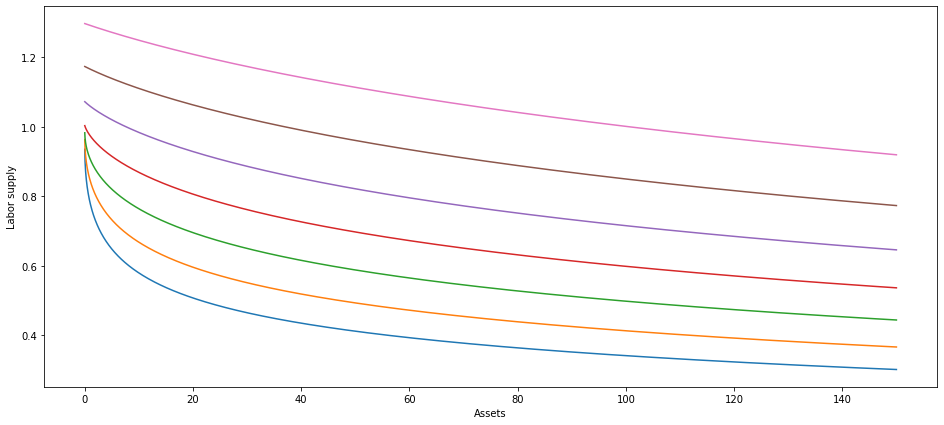

In [59]:
plt.plot(ss0.internals['household']['a_grid'], ss0.internals['household']['n'].T)
plt.xlabel('Assets'), plt.ylabel('Labor supply')
plt.show()

In [60]:
@simple
def nkpc(pi, w, Z, Y, r, mu, kappa):
    nkpc_res = kappa * (w / Z - 1 / mu) + Y(+1) / Y * (1 + pi(+1)).apply(np.log) / (1 + r(+1))\
               - (1 + pi).apply(np.log)
    return nkpc_res


blocks = [hh_ext, firm, monetary, fiscal, mkt_clearing, nkpc]
hank = create_model(blocks, name="One-Asset HANK")

print(*hank.blocks, sep='\n')

<SimpleBlock 'monetary'>
<SimpleBlock 'nkpc'>
<SimpleBlock 'firm'>
<HetBlock 'household' with hetinput 'make_grid_transfers' and with hetoutput `labor_supply'>
<SimpleBlock 'fiscal'>
<SimpleBlock 'mkt_clearing'>


In [61]:
ss = hank.steady_state(ss0)

for k in ss0.keys():
    assert np.all(np.isclose(ss[k], ss0[k]))

In [62]:
T = 300
exogenous = ['rstar', 'Transfer', 'Z', 'tauc']
unknowns = ['pi', 'w', 'Y', 'B']
targets = ['nkpc_res', 'asset_mkt', 'labor_mkt', 'govt_res']

# general equilibrium jacobians
G = hank.solve_jacobian(ss, unknowns, targets, exogenous, T=T)

print(G)

<JacobianDict outputs=['pi', 'w', 'Y', 'B', 'A', 'C', 'N', 'NE', 'L', 'Div', 'r', 'i', 'govt_res', 'asset_mkt', 'labor_mkt', 'goods_mkt', 'nkpc_res'], inputs=['rstar', 'Transfer', 'Z', 'tauc']>


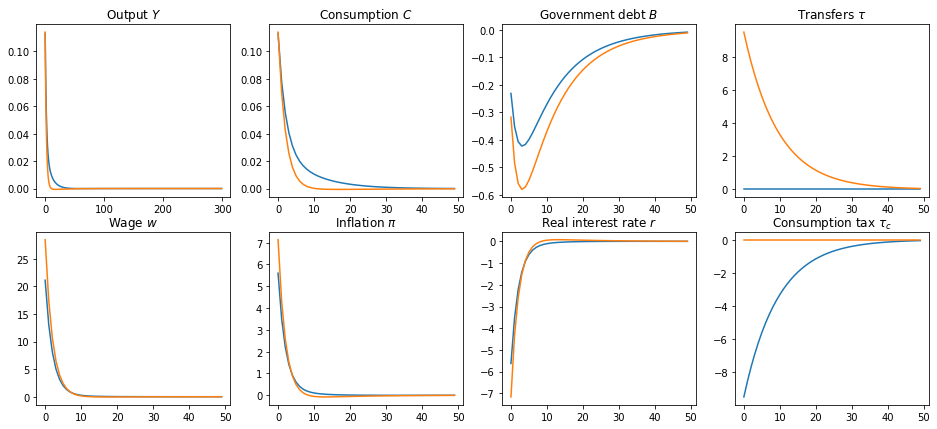

In [69]:
rhos = 0.9
drstar = -0.0025 * 0 * rhos ** (np.arange(T)[:, np.newaxis])
dtstar = 0.00095 * rhos ** (np.arange(T)[:, np.newaxis])

dY = G['Y']['rstar'] @ drstar
dC = G['C']['rstar'] @ drstar
dN = G['L']['rstar'] @ drstar
dB = G['A']['rstar'] @ drstar
dw = G['w']['rstar'] @ drstar
dpi = G['pi']['rstar'] @ drstar
dr = G['r']['rstar'] @ drstar
di = G['i']['rstar'] @ drstar

dYt = G['Y']['Transfer'] @ dtstar
dCt = G['C']['Transfer'] @ dtstar
dNt = G['L']['Transfer'] @ dtstar
dBt = G['A']['Transfer'] @ dtstar
dwt = G['w']['Transfer'] @ dtstar
dpit = G['pi']['Transfer'] @ dtstar
drt = G['r']['Transfer'] @ dtstar

dYc = G['Y']['tauc'] @ -dtstar
dCc = G['C']['tauc'] @ -dtstar
dNc = G['L']['tauc'] @ -dtstar
dBc = G['A']['tauc'] @ -dtstar
dwc = G['w']['tauc'] @ -dtstar
dpic = G['pi']['tauc'] @ -dtstar
drc = G['r']['tauc'] @ -dtstar
#dic = G['i']['tauc'] @ drstar

plt.rcParams["figure.figsize"] = (16,7)
fig, ax = plt.subplots(2, 4)
l1, = ax[0, 0].plot(100 * dYc[:500, :])
l2, = ax[0, 0].plot(100 * dYt[:500, :])
ax[0, 0].set_title(r'Output $Y$')

ax[0, 1].plot(100 * dCc[:50, :])
ax[0, 1].plot(100 * dCt[:50, :])
ax[0, 1].set_title(r'Consumption $C$')

ax[0, 2].plot(100 * dBc[:50, :])
ax[0, 2].plot(100 * dBt[:50, :])
ax[0, 2].set_title(r'Government debt $B$')

ax[0, 3].plot(10000 * np.zeros(50))
ax[0, 3].plot(10000 * dtstar[:50])
ax[0, 3].set_title(r'Transfers $\tau$')

ax[1, 0].plot(10000 * dwc[:50, :])
ax[1, 0].plot(10000 * dwt[:50, :])
ax[1, 0].set_title(r'Wage $w$')

ax[1, 1].plot(10000 * dpic[:50, :])
ax[1, 1].plot(10000 * dpit[:50, :])
ax[1, 1].set_title(r'Inflation $\pi$')

ax[1, 2].plot(10000 * drc[:50, :])
ax[1, 2].plot(10000 * drt[:50, :])
ax[1, 2].set_title(r'Real interest rate $r$')

#ax[1, 3].plot(10000 * di[:50])
#ax[1, 3].plot(10000 * dic[:50])
#ax[1, 3].set_title(r'Nominal interest rate $i$')

ax[1, 3].plot(10000 * -dtstar[:50])
ax[1, 3].plot(10000 * np.zeros(50))
ax[1, 3].set_title(r'Consumption tax $\tau_c$')

#ax.legend((l1, l2), ('MonPol', 'Check'), loc='upper right', shadow=True)
plt.show()